In [1]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
from math import ceil, sqrt
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import sys
sys.path.append('../')
from data.datasets import SSWEDataset
from neuralop.utils import count_model_params
from matplotlib import pyplot as plt
import cmcrameri.cm as cmc
from timeit import default_timer
from utils.losses import EnergyScore, KernelScore, VariogramScore, LpLoss, SphericalL2Loss
from models.fno import FNO, SFNO
from models.pfno import PFNO, PSFNO
from models.pfno import PNO_Wrapper
from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

plt.rcParams['image.cmap'] = "cmc.vik"

# Set torch seed
torch.manual_seed(0)

In [2]:
batch_size = 50
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
eval_horizon = 2
n_train_steps = 2

In [3]:
data_dir = "../data/SSWE/processed/"
train_data = SSWEDataset(data_dir, test = False, pred_horizon = n_train_steps, return_all = True)
test_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon, return_all = True)


x,y,t = train_data.get_coordinates()
L = train_data.get_domain_range()
weights = train_data.weights
nlon = train_data.nlon

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)


n_train = len(train_loader)
n_test = len(test_loader)

# Visualize

In [4]:
for a,u in test_loader:
    break
Lons, Lats = np.meshgrid(y,x)

Text(0.5, 1.0, 'Output')

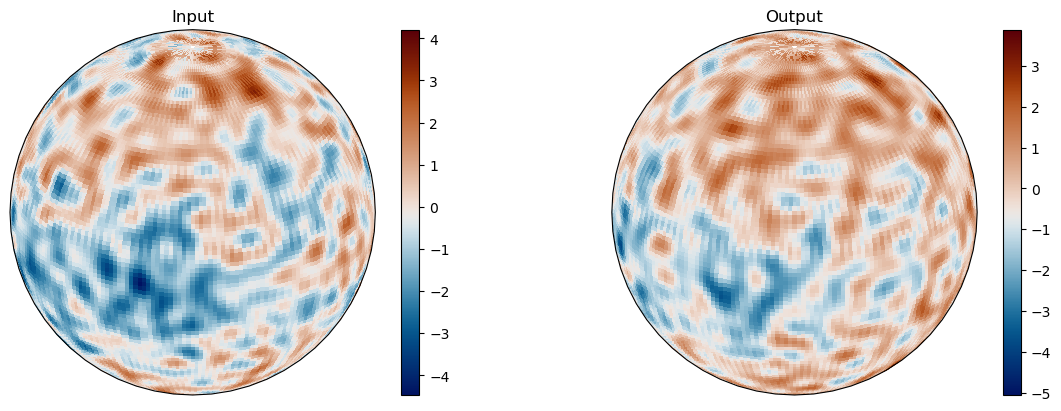

In [5]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(1,2, figsize = (12,4), subplot_kw={'projection': proj}, layout = "constrained")

# contour data over the map.
im = axs[0].pcolormesh(Lons, Lats, a[0,0], transform=ccrs.PlateCarree(), antialiased = False)
plt.colorbar(im)
axs[0].set_title("Input")

im = axs[1].pcolormesh(Lons, Lats, u[0,0,0], transform=ccrs.PlateCarree(), antialiased = False)
plt.colorbar(im)
axs[1].set_title("Output")

# Run Model

In [6]:
# Losses and parameters
l2loss = SphericalL2Loss(nlon = nlon, weights = weights.to(device))
energy_score = EnergyScore(type = "spherical", nlon = nlon, weights = weights.to(device))


# Training parameters
epochs = 10
learning_rate = 0.001
dropout_rate = 0.01
max_train = 1000

In [12]:
dropout_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
dropout_model = dropout_model.to(device)


n_params = count_model_params(dropout_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 277923 parameters.


In [8]:
optimizer = torch.optim.Adam(dropout_model.parameters(),lr=learning_rate)

In [9]:
train_loss = torch.zeros(epochs)

for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,:,0].to(device)

        optimizer.zero_grad()
        out = dropout_model(a)
        
        l2 = l2loss(out, u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.6f}'.format(ep, t2-t1, train_l2))


print("Fine tuning!")
train_loss = torch.zeros(epochs)
for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        optimizer.zero_grad()
        out = dropout_model(a)
        l_step = l2loss(out, u[:,:,0])
        for _ in range(1):
            out = dropout_model(out)
            l_step += l2loss(out, u[:,:,1])
        
        l2 = (l_step)/2
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.6f}'.format(ep, t2-t1, train_l2))

Epoch-0, Time-6.9475, Train-L2-1.529270
Epoch-1, Time-5.8853, Train-L2-1.132306
Epoch-2, Time-5.8911, Train-L2-0.910603
Epoch-3, Time-5.9205, Train-L2-0.815157
Epoch-4, Time-6.0537, Train-L2-0.792253
Epoch-5, Time-6.1824, Train-L2-0.779021
Epoch-6, Time-5.8900, Train-L2-0.771630
Epoch-7, Time-5.9008, Train-L2-0.766330
Epoch-8, Time-6.0631, Train-L2-0.762308
Epoch-9, Time-5.8968, Train-L2-0.760580
Fine tuning!
Epoch-0, Time-10.1663, Train-L2-0.851900
Epoch-1, Time-10.1624, Train-L2-0.826920
Epoch-2, Time-10.2205, Train-L2-0.820550
Epoch-3, Time-10.3451, Train-L2-0.818380
Epoch-4, Time-10.1838, Train-L2-0.817239
Epoch-5, Time-10.1635, Train-L2-0.816487
Epoch-6, Time-10.1580, Train-L2-0.815244
Epoch-7, Time-10.1844, Train-L2-0.814372
Epoch-8, Time-10.1645, Train-L2-0.814043
Epoch-9, Time-10.3699, Train-L2-0.813427


# MCDropout

In [10]:
""" Prediction """
mse_dropout = 0
es_dropout = 0

with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        # Autoregressive steps
        dropout_model.eval()
        for _ in range(eval_horizon-1):
            a = dropout_model(a)
        
        dropout_model.train()
        out = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        mse_dropout += l2loss(out.mean(axis = -1), u).item() / n_test
        es_dropout += energy_score(out, u).item() / n_test


print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.8660841768328724
ES: 0.8040482484968923


# Laplace approximation

In [11]:
la_model = LA_Wrapper(dropout_model, n_samples=n_samples, method = "last_layer", hessian_structure = "full", optimize = True)
la_model.fit(test_loader)

/scratch/buelte/anaconda3/envs/pfno/lib/python3.12/site-packages/laplace/baselaplace.py:222: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  * torch.log(torch.tensor(self.sigma_noise) * sqrt(2 * pi))


In [12]:
""" Prediction """
mse_la = 0
es_la = 0
la_model.model.eval()
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        # Autoregressive steps
        for _ in range(eval_horizon-1):
            a = la_model.model(a)        
        out = la_model.predictive_samples(a)
        mse_la += l2loss(out.mean(axis = -1), u).item() / n_test
        es_la += energy_score(out, u).item() / n_test


print('MSE:', mse_la)
print('ES:', es_la)

MSE: 0.8673175250139343
ES: 0.6392476581634706


# PFNO

In [7]:
# hidden_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
# hidden_model = hidden_model.to(device)
pfno_model = PSFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = None, n_samples = 3,
                   lifting_channels = 256)
pfno_model.to(device)

# pfno_model = PNO_Wrapper(hidden_model, n_samples = 3)
# pfno_model.to(device)

n_params = count_model_params(pfno_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

optimizer = torch.optim.Adam(pfno_model.parameters(),lr=learning_rate)


Our model has 280230 parameters.


In [8]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u[:,:,0].to(device)
        optimizer.zero_grad()
        out = pfno_model(a)
        
        l2 = energy_score(out,u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}'.format(ep, t2-t1, train_l2))

print("Fine tuning!")
for ep in range(epochs):
    t1 = default_timer()
    train_l2 = 0
    for i,sample in enumerate(train_loader):
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        optimizer.zero_grad()
        out = pfno_model(a, n_samples = 10)
        l_step = energy_score(out,u[:,:,0])
        out = pfno_model(out.mean(axis = -1))
        
        l2 = (l_step + energy_score(out,u[:,:,1]))/2
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()
        if i*batch_size >= max_train:
            break

    train_l2 /= n_train
    
    train_loss[ep] = train_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}'.format(ep, t2-t1, train_l2))

Epoch-0, Time-9.0351, Train-L2-1.0910
Epoch-1, Time-7.9323, Train-L2-0.8038
Epoch-2, Time-7.8359, Train-L2-0.6366
Epoch-3, Time-7.9933, Train-L2-0.5608
Epoch-4, Time-8.1926, Train-L2-0.5443
Epoch-5, Time-7.8389, Train-L2-0.5358
Epoch-6, Time-7.8622, Train-L2-0.5315
Epoch-7, Time-7.8350, Train-L2-0.5307
Epoch-8, Time-8.0057, Train-L2-0.5299
Epoch-9, Time-7.8612, Train-L2-0.5281
Fine tuning!
Epoch-0, Time-23.5586, Train-L2-0.6564
Epoch-1, Time-23.5448, Train-L2-0.5921
Epoch-2, Time-23.5125, Train-L2-0.5787
Epoch-3, Time-23.6618, Train-L2-0.5745
Epoch-4, Time-23.4685, Train-L2-0.5732
Epoch-5, Time-23.5009, Train-L2-0.5726
Epoch-6, Time-23.4480, Train-L2-0.5722
Epoch-7, Time-23.4725, Train-L2-0.5719
Epoch-8, Time-23.6922, Train-L2-0.5716
Epoch-9, Time-24.0969, Train-L2-0.5715


In [10]:
pfno_model.eval()
""" Prediction """
mse_pfno = 0
es_pfno = 0
coverage_pfno = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u[:,:,-1].to(device)

        # Autoregressive steps
        for _ in range(eval_horizon-1):
            a = pfno_model(a, n_samples = 10)
            a = a.mean(axis = -1)

        out = pfno_model(a, n_samples = n_samples)
        mse_pfno += l2loss(out.mean(axis = -1), u).item() / n_test
        es_pfno += energy_score(out, u).item() / n_test
        # Calculate coverage
        q_lower = torch.quantile(out,alpha/2, axis = -1)
        q_upper = torch.quantile(out,1-alpha/2, axis = -1)
        coverage_pfno += ((u>q_lower) & (u<q_upper)).float().mean().item() / n_test


print('MSE:', mse_pfno)
print('ES:', es_pfno)
print('Coverage:', coverage_pfno)

MSE: 0.8726250501963704
ES: 0.6154240365685046
Coverage: 0.4409524074622563


# Compare Metrics

In [16]:
print(f"Dropout \nMSE: {mse_dropout} \t ES: {es_dropout}")
print(f"LA \nMSE: {mse_la} \t ES: {es_la}")
print(f"PFNO \nMSE: {mse_pfno} \t ES: {es_pfno}")

Dropout 
MSE: 0.8660841768328724 	 ES: 0.8040482484968923
LA 
MSE: 0.8673175250139343 	 ES: 0.6392476581634706
PFNO 
MSE: 0.8794261922132491 	 ES: 0.6204532200180234


# Visualizations

In [17]:
n_samples = 100

In [18]:
sample = np.random.randint(0,len(test_data))
print(sample)

dropout_model.eval()
""" Prediction """
truth = []
pred_pfno = []
pred_dropout = []
pred_la = []

with torch.no_grad():
    a,u = test_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    # Dropout
    out = dropout_model(a)
    for _ in range(1,eval_horizon-1):
        out = dropout_model(out)
    dropout_model.train()
    dropout_pred = generate_mcd_samples(dropout_model, out, u.shape, n_samples=n_samples)

    # LA
    out = la_model.model(a)
    for _ in range(1,eval_horizon-1):
        out = la_model.model(out)
    la_pred = la_model.predictive_samples(out)

    # PFNO
    out = pfno_model(a)
    for _ in range(1,eval_horizon-1):
        out = pfno_model(out.mean(axis = -1))
    pfno_pred = pfno_model(out.mean(axis = -1), n_samples = n_samples)
        

    pred_dropout.append( dropout_pred )
    pred_pfno.append( pfno_pred )
    pred_la.append( la_pred )
    truth.append( u )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()
pred_la = torch.cat(pred_la, dim = 0).cpu().numpy()
truth = torch.cat(truth, dim = 0).cpu().numpy()

52


In [19]:
idx = 0
preds = [pred_dropout, pred_la, pred_pfno]

Text(0, 0.5, 'PFNO')

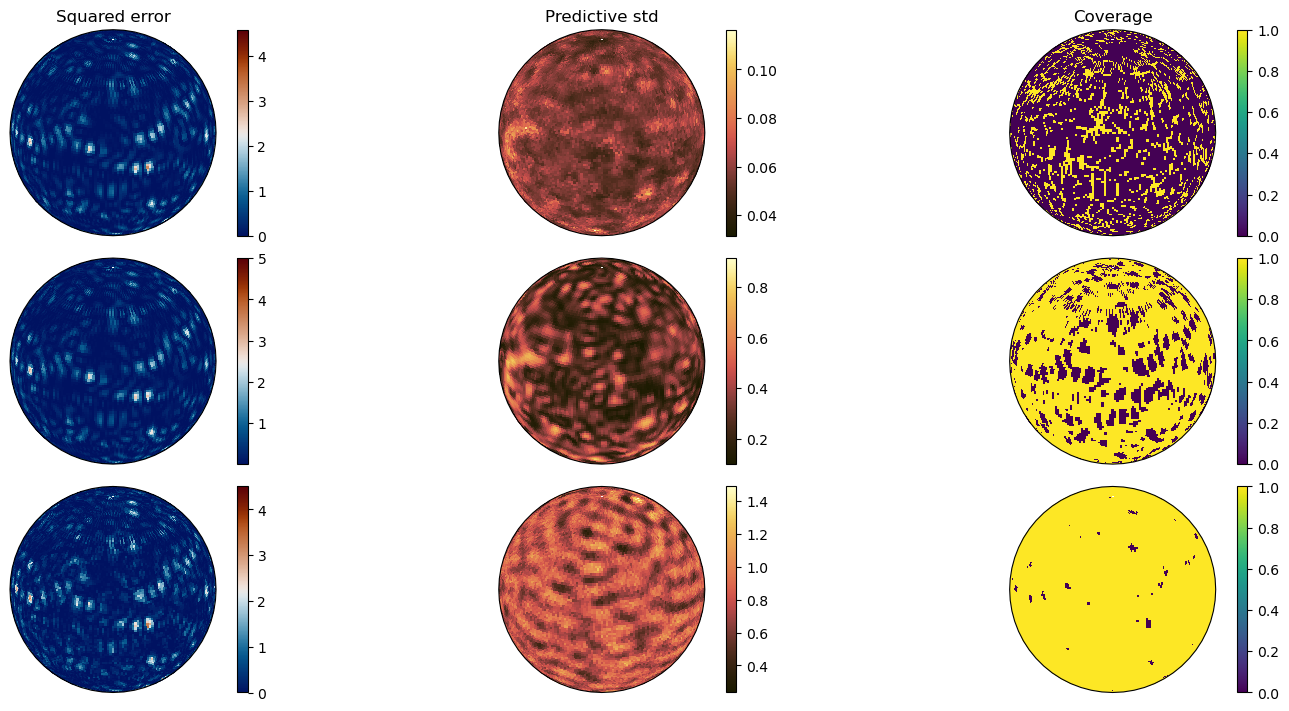

In [20]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,3, figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    # im = axs[i,0].pcolormesh(Lons, Lats, truth[idx,0], transform=ccrs.PlateCarree(), antialiased = False)
    # plt.colorbar(im)

    im = axs[i,0].pcolormesh(Lons, Lats, np.power(pred[idx,0].mean(axis = -1)-truth[idx,0],2), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,1].pcolormesh(Lons, Lats, pred[idx,0].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,0],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,0],1-alpha/2, axis = -1)
    coverage = (truth[idx,0]>q_lower) & (truth[idx,0]<q_upper)

    im = axs[i,2].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0,0].set_title("Squared error")
axs[0,1].set_title("Predictive std")
axs[0,2].set_title("Coverage")

axs[0,0].set_ylabel("MCDropout")
axs[1,0].set_ylabel("LA")
axs[2,0].set_ylabel("PFNO")

Text(0, 0.5, 'PFNO')

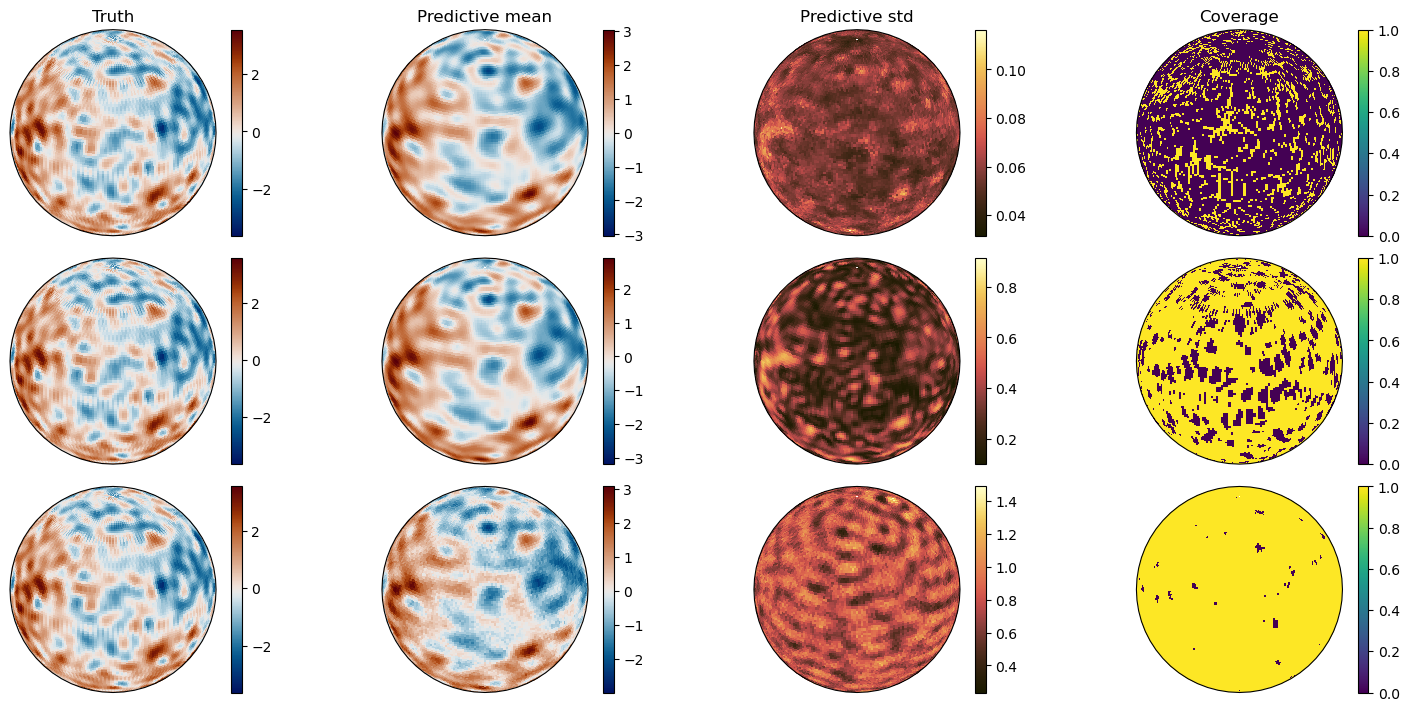

In [21]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,4, figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    im = axs[i,0].pcolormesh(Lons, Lats, truth[idx,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,1].pcolormesh(Lons, Lats, pred[idx,0].mean(axis = -1), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[i,2].pcolormesh(Lons, Lats, pred[idx,0].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,0],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,0],1-alpha/2, axis = -1)
    coverage = (truth[idx,0]>q_lower) & (truth[idx,0]<q_upper)

    im = axs[i,3].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0,0].set_title("Truth")
axs[0,1].set_title("Predictive mean")    
axs[0,2].set_title("Predictive std")
axs[0,3].set_title("Coverage")

axs[0,0].set_ylabel("MCDropout")
axs[1,0].set_ylabel("LA")
axs[2,0].set_ylabel("PFNO")

# Plot prediction history

In [22]:
#sample = np.random.randint(0,n_test)

eval_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon, return_all = True)

dropout_model.eval()
""" Prediction """
truth = []
pred_pfno = []
pred_dropout = []

with torch.no_grad():
    a,u = eval_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    # Dropout
    out = dropout_model(a)
    pred_dropout.append( out )
    for _ in range(1,eval_horizon):
        out = dropout_model(out)
        pred_dropout.append( out )

    # PFNO
    out = pfno_model(a, n_samples = n_samples)
    out = out.mean(axis = -1)
    pred_pfno.append( out )

    for _ in range(1,eval_horizon):        
        out = pfno_model(out, n_samples = n_samples)
        out = out.mean(axis = -1)
        pred_pfno.append( out )

truth = u.squeeze().cpu().numpy()
inp = a.squeeze().cpu().numpy()
pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
pred_dropout = torch.cat(pred_dropout, dim = 0).cpu().numpy()

Text(0, 0.5, 'PFNO')

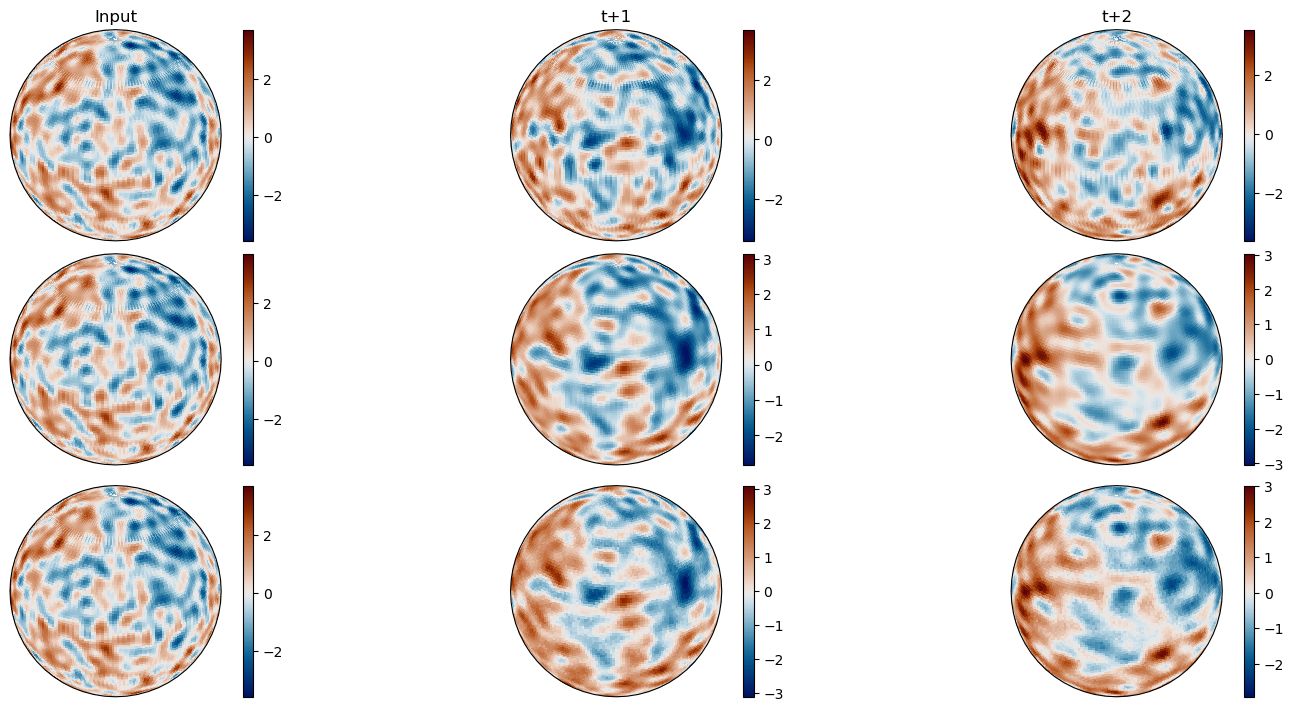

In [26]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(3,(eval_horizon+1), figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i in range(3):
    im = axs[i,0].pcolormesh(Lons, Lats, inp[0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)
    axs[0,0].set_title("Input")

for i in range(eval_horizon):
    im = axs[0,i+1].pcolormesh(Lons, Lats, truth[0,i], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[1,i+1].pcolormesh(Lons, Lats, pred_dropout[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[2,i+1].pcolormesh(Lons, Lats, pred_pfno[i,0], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    axs[0,i+1].set_title(f"t+{i+1}")


axs[0,0].set_ylabel("Truth")
axs[1,0].set_ylabel("Dropout")
axs[2,0].set_ylabel("PFNO")

# Tests

In [6]:
batch_size = 50
n_samples = 100 # Samples to create from predictive distributions
alpha = 0.05 # Parameter for confidence interval
eval_horizon = 5
n_train_steps = 2

In [7]:
data_dir = "../data/SSWE/processed/"
train_data = SSWEDataset(data_dir, test = False, pred_horizon = n_train_steps, return_all = True)
test_data = SSWEDataset(data_dir, test = True, pred_horizon = eval_horizon, return_all = True)
train_data, val_data = random_split(train_data, lengths = [0.8,0.2], generator = torch.Generator().manual_seed(42))


x,y,t = test_data.get_coordinates()
L = test_data.get_domain_range()
weights = test_data.weights
nlon = test_data.nlon

val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)


n_train = len(train_loader)
n_val = len(val_data)
n_test = len(test_data)

In [34]:
# hidden_model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = dropout_rate)
# hidden_model = hidden_model.to(device)
pfno_model = PSFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense', dropout = None, n_samples = 3,
                   lifting_channels = 64)
pfno_model.to(device)

# pfno_model = PNO_Wrapper(hidden_model, n_samples = 3)
# pfno_model.to(device)

n_params = count_model_params(pfno_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()

pfno_model.load_state_dict(torch.load("../results/sswe_test/normal.pt"))


Our model has 273318 parameters.


<All keys matched successfully>

In [35]:
# Losses and parameters
l2loss = SphericalL2Loss(nlon = nlon, weights = weights.to(device))
energy_score = EnergyScore(type = "spherical", nlon = nlon, weights = weights.to(device))

In [36]:
pfno_model.eval()
""" Prediction """
mse_pfno = 0
es_pfno = 0
coverage_pfno = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u[:,:,-1].to(device)
        batch_size = a.shape[0]

        # Autoregressive steps
        for _ in range(eval_horizon-1):
            a = pfno_model(a, n_samples = 10)
            a = a.mean(axis = -1)

        out = pfno_model(a, n_samples = n_samples)
        mse_pfno += l2loss(out.mean(axis = -1), u).item() * batch_size / n_test
        es_pfno += energy_score(out, u).item() *batch_size / n_test
        # Calculate coverage
        q_lower = torch.quantile(out,alpha/2, axis = -1)
        q_upper = torch.quantile(out,1-alpha/2, axis = -1)
        coverage_pfno += ((u>q_lower) & (u<q_upper)).float().mean().item() *batch_size / n_test



print('MSE:', mse_pfno)
print('ES:', es_pfno)
print(f"Coverage: {coverage_pfno*100:.4f}%")

MSE: 1.0699061161132124
ES: 0.7667232623673822
Coverage: 85.8285%


In [49]:
sample = np.random.randint(0,len(test_data))
print(sample)

""" Prediction """
truth = []
pred_pfno = []
with torch.no_grad():
    a,u = test_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u[:,-1].to(device).unsqueeze(0)
    # PFNO
    out = pfno_model(a, n_samples = n_samples)
    for _ in range(1,eval_horizon-1):
        out = pfno_model(out.mean(axis = -1))
    pfno_pred = pfno_model(out.mean(axis = -1), n_samples = n_samples)
        

    pred_pfno.append( pfno_pred )
    truth.append( u )


pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()
truth = torch.cat(truth, dim = 0).cpu().numpy()

25


In [50]:
idx = 0
var = 2
preds = [pred_pfno]

Text(0, 0.5, 'PFNO')

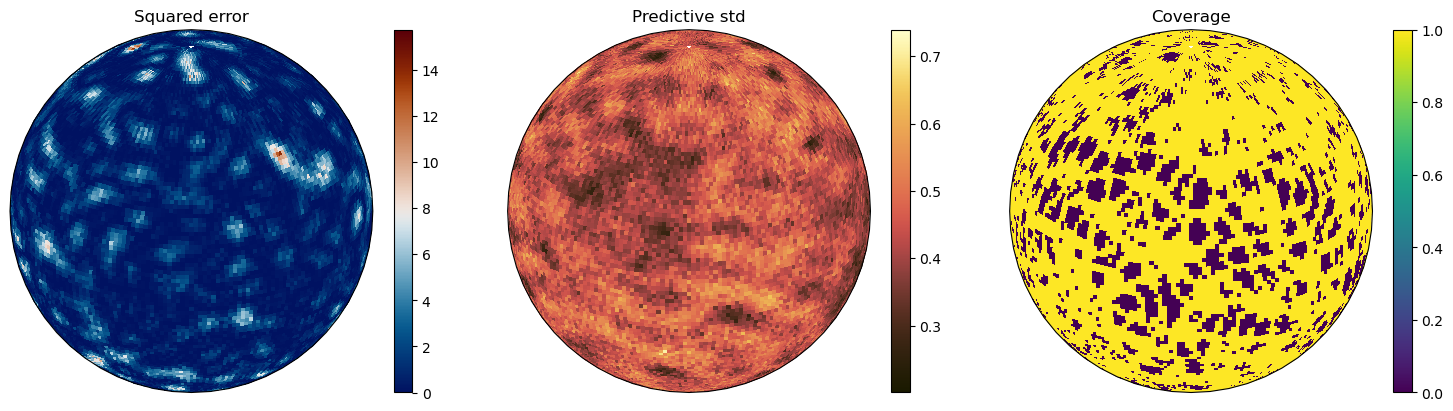

In [51]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(1,3, figsize = (15,4), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    # im = axs[i,0].pcolormesh(Lons, Lats, truth[idx,0], transform=ccrs.PlateCarree(), antialiased = False)
    # plt.colorbar(im)

    im = axs[0].pcolormesh(Lons, Lats, np.power(pred[idx,var].mean(axis = -1)-truth[idx,0],2), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[1].pcolormesh(Lons, Lats, pred[idx,var].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,var],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,var],1-alpha/2, axis = -1)
    coverage = (truth[idx,var]>q_lower) & (truth[idx,var]<q_upper)

    im = axs[2].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0].set_title("Squared error")
axs[1].set_title("Predictive std")
axs[2].set_title("Coverage")

axs[0].set_ylabel("MCDropout")
axs[0].set_ylabel("LA")
axs[0].set_ylabel("PFNO")

Text(0, 0.5, 'PFNO')

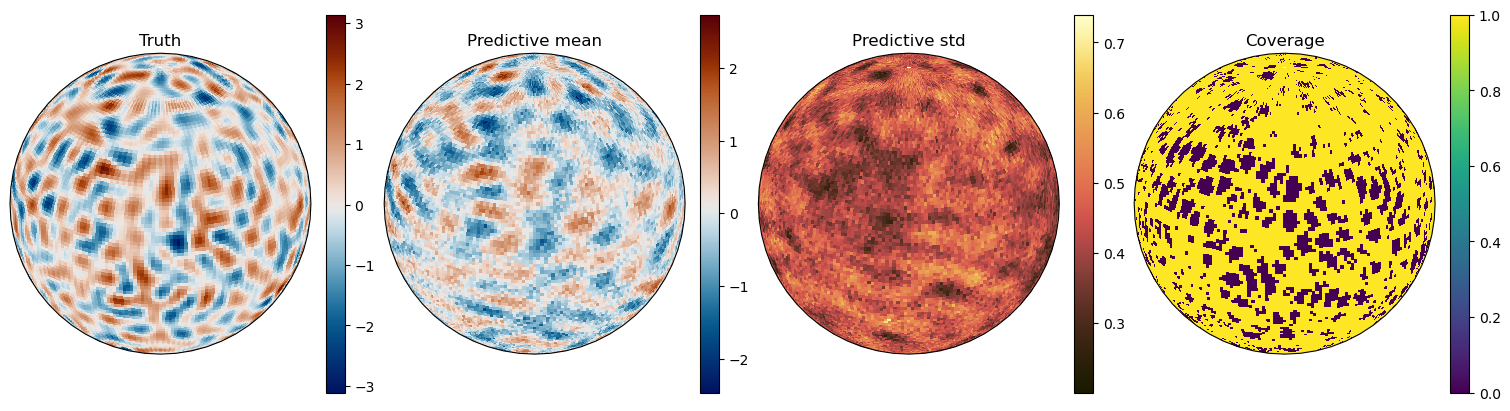

In [52]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(1,4, figsize = (15,4), subplot_kw={'projection': proj}, layout = "constrained")
for i, pred in enumerate(preds):
    im = axs[0].pcolormesh(Lons, Lats, truth[idx,var], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[1].pcolormesh(Lons, Lats, pred[idx,var].mean(axis = -1), transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    im = axs[2].pcolormesh(Lons, Lats, pred[idx,var].std(axis = -1), transform=ccrs.PlateCarree(), antialiased = False, cmap = "cmc.lajolla")
    plt.colorbar(im)

    # Calculate coverage
    q_lower = np.quantile(pred[idx,var],alpha/2, axis = -1)
    q_upper = np.quantile(pred[idx,var],1-alpha/2, axis = -1)
    coverage = (truth[idx,var]>q_lower) & (truth[idx,var]<q_upper)

    im = axs[3].pcolormesh(Lons, Lats, coverage, transform=ccrs.PlateCarree(), antialiased = False, cmap = "viridis")
    plt.colorbar(im)


axs[0].set_title("Truth")
axs[1].set_title("Predictive mean")    
axs[2].set_title("Predictive std")
axs[3].set_title("Coverage")

axs[0].set_ylabel("MCDropout")
axs[0].set_ylabel("LA")
axs[0].set_ylabel("PFNO")

In [53]:
""" Prediction """
truth = []
pred_pfno = []


with torch.no_grad():
    a,u = test_data.__getitem__(sample)
    a = a.to(device).unsqueeze(0)
    u = u.to(device).unsqueeze(0)
    # PFNO
    out = pfno_model(a, n_samples = n_samples)
    out = out.mean(axis = -1)
    pred_pfno.append( out )

    for _ in range(1,eval_horizon):        
        out = pfno_model(out, n_samples = n_samples)
        out = out.mean(axis = -1)
        pred_pfno.append( out )

truth = u.squeeze().cpu().numpy()
inp = a.squeeze().cpu().numpy()
pred_pfno = torch.cat(pred_pfno, dim = 0).cpu().numpy()

Text(0, 0.5, 'PFNO')

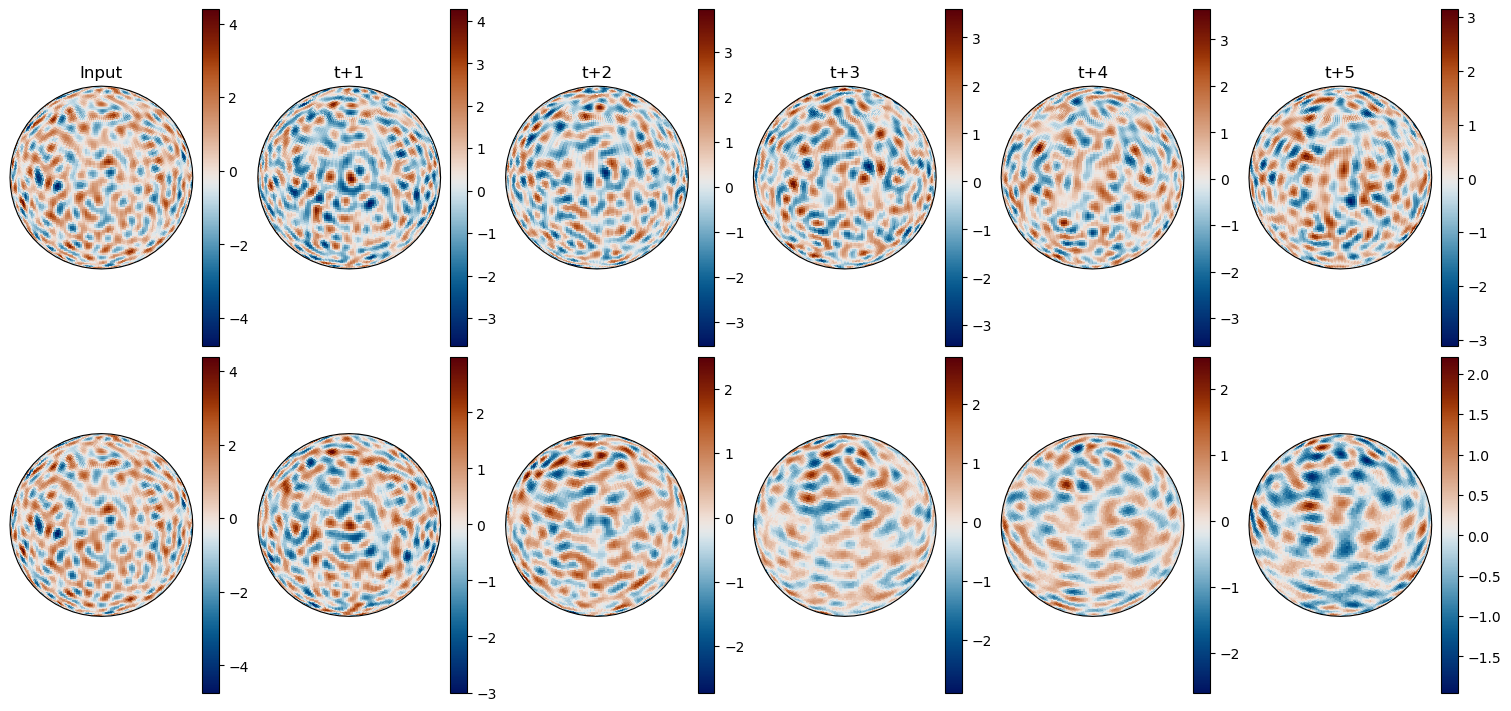

In [54]:
proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=25.0)
fig, axs = plt.subplots(2,(eval_horizon+1), figsize = (15,7), subplot_kw={'projection': proj}, layout = "constrained")
for i in range(2):
    im = axs[i,0].pcolormesh(Lons, Lats, inp[var], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)
    axs[0,0].set_title("Input")

for i in range(eval_horizon):
    im = axs[0,i+1].pcolormesh(Lons, Lats, truth[var,i], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)


    im = axs[1,i+1].pcolormesh(Lons, Lats, pred_pfno[i,var], transform=ccrs.PlateCarree(), antialiased = False)
    plt.colorbar(im)

    axs[0,i+1].set_title(f"t+{i+1}")


axs[0,0].set_ylabel("Truth")
axs[1,0].set_ylabel("PFNO")